In [1]:
import pickle
import torch
import copy
import random

import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
SEED = 69

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=24
BATCH_SIZE=64

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transform_list = [transforms.Resize((RESCALE_SIZE, RESCALE_SIZE))]
        if self.mode != 'test':
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        pretransform = transforms.Compose(transform_list)
        
        postransform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
        x = self.load_sample(self.files[index])
        x = pretransform(x)
        x = (np.array(x) / 255).astype('float32')
        x = postransform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y


In [4]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [5]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [6]:
def create_dct_path_labels(train_files, train_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_files, train_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [7]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')

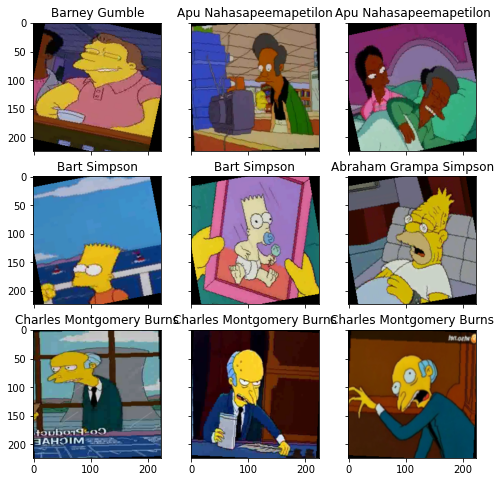

In [8]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [9]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        #    opt, mode='max', factor=0.1, patience=10, verbose=False)
        best_acc = 0.0
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            scheduler.step()            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))            
            if val_acc > best_acc:
                best_model_wghts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wghts, './model/resnet18_pretrained_lrstep.mdl')
                best_acc = val_acc
    print(best_acc)        
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [10]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')
n_classes = len(np.unique(train_val_labels))

In [11]:
model = models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(in_features=model.fc.in_features, out_features=n_classes)
model = model.to('cuda')
history = train(train_dataset, val_dataset, model=model, epochs=4, batch_size=BATCH_SIZE)

epoch:   0%|                                                                                     | 0/4 [00:00<?, ?it/s]

loss 2.392349718868315


epoch:  25%|███████████████████▎                                                         | 1/4 [01:34<04:43, 94.40s/it]


Epoch 001 train_loss: 2.3923     val_loss 1.7909 train_acc 0.4099 val_acc 0.5654
loss 1.5525312280349894


epoch:  50%|██████████████████████████████████████▌                                      | 2/4 [03:04<03:06, 93.16s/it]


Epoch 002 train_loss: 1.5525     val_loss 1.4252 train_acc 0.6138 val_acc 0.6239
loss 1.2957015545310824


epoch:  75%|█████████████████████████████████████████████████████████▊                   | 3/4 [04:35<01:32, 92.51s/it]


Epoch 003 train_loss: 1.2957     val_loss 1.2698 train_acc 0.6647 val_acc 0.6690
loss 1.1553410637280652


epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 4/4 [06:06<00:00, 91.53s/it]


Epoch 004 train_loss: 1.1553     val_loss 1.1989 train_acc 0.6974 val_acc 0.6831
tensor(0.6831, device='cuda:0', dtype=torch.float64)


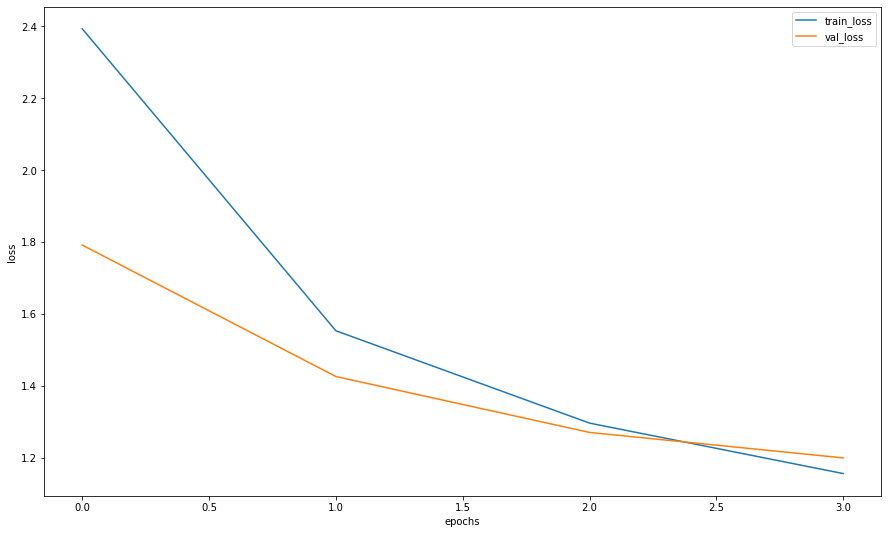

In [12]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

epoch:   0%|                                                                                    | 0/24 [00:00<?, ?it/s]

loss 4.188078461527062


epoch:   4%|███▏                                                                       | 1/24 [02:05<48:07, 125.54s/it]


Epoch 001 train_loss: 4.1881     val_loss 3.2503 train_acc 0.0950 val_acc 0.1027
loss 3.229961462439178


epoch:   8%|██████▎                                                                    | 2/24 [04:10<46:01, 125.51s/it]


Epoch 002 train_loss: 3.2300     val_loss 3.1709 train_acc 0.1020 val_acc 0.1250
loss 2.8401330096889406


epoch:  12%|█████████▍                                                                 | 3/24 [06:16<43:55, 125.51s/it]


Epoch 003 train_loss: 2.8401     val_loss 2.6378 train_acc 0.2097 val_acc 0.2844
loss 2.39086363874773


epoch:  17%|████████████▌                                                              | 4/24 [08:21<41:49, 125.47s/it]


Epoch 004 train_loss: 2.3909     val_loss 2.1553 train_acc 0.3335 val_acc 0.4147
loss 2.0188484947600815


epoch:  21%|███████████████▋                                                           | 5/24 [10:27<39:44, 125.52s/it]


Epoch 005 train_loss: 2.0188     val_loss 1.9141 train_acc 0.4403 val_acc 0.4755
loss 1.6768868174307454


epoch:  25%|██████████████████▊                                                        | 6/24 [12:32<37:39, 125.51s/it]


Epoch 006 train_loss: 1.6769     val_loss 1.4817 train_acc 0.5335 val_acc 0.5910
loss 1.4112523147110674


epoch:  29%|█████████████████████▉                                                     | 7/24 [14:38<35:34, 125.56s/it]


Epoch 007 train_loss: 1.4113     val_loss 1.2965 train_acc 0.6024 val_acc 0.6383
loss 1.0282964837649158


epoch:  33%|█████████████████████████                                                  | 8/24 [16:44<33:29, 125.60s/it]


Epoch 008 train_loss: 1.0283     val_loss 1.0634 train_acc 0.7095 val_acc 0.7060
loss 0.9266226327822334


epoch:  38%|████████████████████████████▏                                              | 9/24 [18:49<31:23, 125.55s/it]


Epoch 009 train_loss: 0.9266     val_loss 1.0017 train_acc 0.7393 val_acc 0.7237
loss 0.879469491808726


epoch:  42%|██████████████████████████████▊                                           | 10/24 [20:55<29:17, 125.55s/it]


Epoch 010 train_loss: 0.8795     val_loss 0.9362 train_acc 0.7566 val_acc 0.7449
loss 0.8173633695810697


epoch:  46%|█████████████████████████████████▉                                        | 11/24 [23:00<27:11, 125.53s/it]


Epoch 011 train_loss: 0.8174     val_loss 0.9073 train_acc 0.7719 val_acc 0.7515
loss 0.7657380966961547


epoch:  50%|█████████████████████████████████████                                     | 12/24 [25:06<25:07, 125.63s/it]


Epoch 012 train_loss: 0.7657     val_loss 0.8711 train_acc 0.7872 val_acc 0.7630
loss 0.7177997925025168


epoch:  54%|████████████████████████████████████████                                  | 13/24 [27:12<23:02, 125.68s/it]


Epoch 013 train_loss: 0.7178     val_loss 0.8566 train_acc 0.7979 val_acc 0.7736
loss 0.6745979869797794


epoch:  58%|███████████████████████████████████████████▏                              | 14/24 [29:17<20:56, 125.61s/it]


Epoch 014 train_loss: 0.6746     val_loss 0.8189 train_acc 0.8108 val_acc 0.7809
loss 0.5853022882969613


epoch:  62%|██████████████████████████████████████████████▎                           | 15/24 [31:23<18:51, 125.68s/it]


Epoch 015 train_loss: 0.5853     val_loss 0.7819 train_acc 0.8347 val_acc 0.7864
loss 0.5700540470125615


epoch:  67%|█████████████████████████████████████████████████▎                        | 16/24 [33:29<16:45, 125.66s/it]


Epoch 016 train_loss: 0.5701     val_loss 0.7693 train_acc 0.8404 val_acc 0.7959
loss 0.5567186393681147


epoch:  71%|████████████████████████████████████████████████████▍                     | 17/24 [35:34<14:39, 125.58s/it]


Epoch 017 train_loss: 0.5567     val_loss 0.7694 train_acc 0.8445 val_acc 0.7955
loss 0.5470538849224958


epoch:  75%|███████████████████████████████████████████████████████▌                  | 18/24 [37:40<12:33, 125.55s/it]


Epoch 018 train_loss: 0.5471     val_loss 0.7761 train_acc 0.8480 val_acc 0.7942
loss 0.5489301493499761


epoch:  79%|██████████████████████████████████████████████████████████▌               | 19/24 [39:53<10:39, 127.95s/it]


Epoch 019 train_loss: 0.5489     val_loss 0.7872 train_acc 0.8473 val_acc 0.7920
loss 0.5309293604263837


epoch:  83%|█████████████████████████████████████████████████████████████▋            | 20/24 [42:07<08:39, 129.78s/it]


Epoch 020 train_loss: 0.5309     val_loss 0.7677 train_acc 0.8521 val_acc 0.8023
loss 0.5324492872596477


epoch:  88%|████████████████████████████████████████████████████████████████▊         | 21/24 [44:23<06:34, 131.39s/it]


Epoch 021 train_loss: 0.5324     val_loss 0.7772 train_acc 0.8503 val_acc 0.7970
loss 0.5171728529165404


epoch:  92%|███████████████████████████████████████████████████████████████████▊      | 22/24 [46:40<04:26, 133.23s/it]


Epoch 022 train_loss: 0.5172     val_loss 0.7608 train_acc 0.8570 val_acc 0.8008
loss 0.5168135096124131


epoch:  96%|██████████████████████████████████████████████████████████████████████▉   | 23/24 [48:49<02:11, 131.96s/it]


Epoch 023 train_loss: 0.5168     val_loss 0.7495 train_acc 0.8556 val_acc 0.8001
loss 0.5143330253590326


epoch: 100%|██████████████████████████████████████████████████████████████████████████| 24/24 [51:03<00:00, 127.65s/it]


Epoch 024 train_loss: 0.5143     val_loss 0.7592 train_acc 0.8570 val_acc 0.7997
tensor(0.8023, device='cuda:0', dtype=torch.float64)


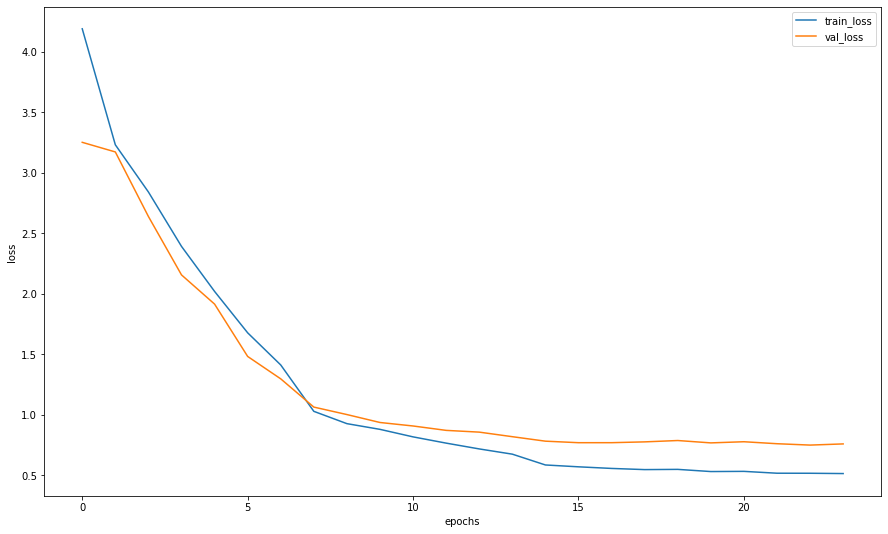

In [13]:
for param in model.parameters():
    param.requires_grad = True
    
history = train(train_dataset, val_dataset, model=model, epochs=EPOCHS, batch_size=BATCH_SIZE)
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [18]:
model.load_state_dict(torch.load('./model/resnet18_pretrained_lrstep.mdl'))

<All keys matched successfully>

In [19]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [20]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))
idxs = list(map(int, np.random.uniform(0,1000, 20)))

imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]
probs_ims = predict(model, imgs)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
preds_class = [label_encoder.classes_[i] for i in y_pred]

f1_score(actual_labels, y_pred, average='weighted')

0.8944444444444445

In [21]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.to_csv('./out/my_submit_resnet18_pretrained_lrstep.csv', index=False)
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
